## Food item modeling
The Branded food items are not labeled or categorized but have an ingredients list provided by the manufacturer.  The ingredients in a food label is an ordered listed in *decreasing order by weight*.  
* For a simple categorization method, observe how item similarities change as the number of elements (ingredients) are successively increased
E.g. use the first 5 items to calculate cosine similarity for each food item, then cluster.  

In [1]:
%matplotlib inline

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import re
import string
import pickle
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Retrieve pickled standard reference food items (175228 total)
with open("../../../food_data/br_food_items_list","r") as f: 
    food_items = pickle.load(f)

In [4]:
# Food item IDs, names, and their ingredients
food_items[:5]

[(u'45001524',
  u'MOCHI ICE CREAM BONBONS, UPC: 019022128593',
  u'ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STRAWBERRIES (STRAWBERRIES, SUGAR), CORN SYRUP SOLIDS, SKIM MILK, WHEY, NATURAL FLAVOR, GUAR GUM, MONO & DIGLYCERIDES, BEET JUICE AND BEET POWDER (FOR COLOR), CELLULOSE GUM, LOCUST BEAN GUM, CARRAGEENAN. COATING INGREDIENTS: SUGAR, WATER, RICE FLOUR, TREHALOSE, EGG WHITES, BEET JUICE AND BEET POWDER (FOR COLOR), DUSTED WITH CORN & POTATO STARCH'),
 (u'45001528',
  u'CHIPOTLE BARBECUE SAUCE, UPC: 5051379043735',
  u'WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLED VINEGAR, CONTAINS 2% OR LESS OF: CORN STARCH, SALT, DRIED CHIPOTLE PEPPER, NATURAL SMOKE FLAVOR, MUSTARD FLOUR, DRIED GARLIC, DRIED ONION, SPICES.'),
 (u'45001529',
  u'BARBECUE SAUCE, UPC: 5051379009434',
  u'SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE, MOLASSES MODIFIED CORN STARCH, SALT, PINEAPPLE JUICE CONCENTRATE, CONTAINS 1% OR LESS OF: JALAPENO PEPPERS, SPICE, CARAMEL COLOR, NATURAL FLAVOR, XANTHAN GUM, GARLIC

In [5]:
# isolate the ingredients list from food_items
ingredients_list = [a[2] for a in food_items]

## Parsing individual ingredients from `ingredients_list`

In [6]:
# Obtain the first ingredient of each food item.
# First pass: Split on commas and evaluate
# Without stemming or further processing, this reduces the list to .16 of origina
first_ingredient = [a.split(',')[0] for a in ingredients_list]

print "count of all first terms:", len(first_ingredient)
print "count of unique terms:", len(set(first_ingredient))
print "ratio: {}".format(1.*len(set(first_ingredient))/len(first_ingredient))

count of all first terms: 175228
count of unique terms: 28208
ratio: 0.160978838998


In [7]:
# It is observed that there are many ingredients lists are not separated by commas: 
# periods, hyphens, semicolons, forward slashes, or no punctuation at all (spaces) are used
# There are also ingredients lists split into sub-components, either enclosed 
# in parentheses or following a semicolon.  
# View some samples: 
[a for a in first_ingredient if len(a.split()) > 10][:10]

[u'ORGANIC ENRICHED PETITE PASTA SHELLS [ORGANIC DURUM WHEAT SEMOLINA FLOUR (NIACIN',
 u'MADE WITH ROASTED PEANUTS AND SUGAR. CONTAINS 2% OR LESS OF MOLASSES',
 u'ORGANIC CULTURED PASTEURIZED REDUCED FAT MILK. LIVE ACTIVE CULTURES: L. ACIDOPHILUS',
 u'PASTEURIZED AND CULTURED ORGANIC SOYMILK (FILTERED WATER AND GROUND ORGANIC SOYBEANS)',
 u'CULTURED PASTEURIZED GRADE A LOWFAT MILK AND NONFAT MILK SOLIDS. CONTAINS ACTIVE YOGURT CULTURES.',
 u'TURBINADO SUGAR; WHOLE WHEAT PASTRY FLOUR; COCOA; MILLED FLAX SEED; SALT.',
 u'CANE SUGAR*; **COCOA*; CHOCOLATE*; CINNAMON*; CAYENNE PEPPER*; MILK*(LESS THAN0. 1%). *ORGANIC',
 u'IDAHO POTATOES* WITH EMULSIFIER (MONO & DIGLYCERIDES) AND PRESERVATIVES (SODIUM ACID PYROPHOSPHATE',
 u'RAVIOLI INGREDIENTS: ENRICHED EXTRA FANCY DURUM FLOUR AND SEMOLINA (DURUM WHEAT FLOUR',
 u'CASSIA ACUTIFOLIA DELILE (SENNA LEAF); FOLIUM SENNAE; TINNEVELLY SENNA; CASSIA ANGUSTIFOLIA VAHL.']

In [8]:
# Get count of all punctuations in ingredients list
all_punctuation_counter = collections.Counter(re.findall(r'[!"#$%&\\\'()*+,-./:;<=>?@\[\]^_`{|}~\']', 
                                                         " ".join(ingredients_list)))
all_punctuation_counter.most_common()

[(u',', 1767190),
 (u'(', 237166),
 (u')', 219593),
 (u'.', 149518),
 (u':', 42010),
 (u'[', 36531),
 (u'%', 35382),
 (u']', 33167),
 (u'*', 31914),
 (u'-', 25488),
 (u'&', 17422),
 (u'/', 16643),
 (u'#', 9427),
 (u';', 4690),
 (u"'", 4684),
 (u'{', 3074),
 (u'}', 2786),
 (u'+', 1364),
 (u'"', 419),
 (u'_', 207),
 (u'>', 184),
 (u'!', 169),
 (u'<', 150),
 (u'?', 55),
 (u'=', 20),
 (u'|', 11),
 (u'\\', 7),
 (u'$', 6),
 (u'@', 5),
 (u'`', 2)]

In [9]:
# Frequency of punctuation occurrences for each ingredient list.  
punctuation_counter = []
for a in ingredients_list: 
    punctuation_counter.append(collections.Counter(re.findall(r'[!"#$%&\\\\\'()*+,-./:;<=>?@\[\]^_`{|}~\']',a)).most_common())

In [10]:
# Frequency of most frequent punctuation per food item 
#  (punctuations with highest frequency in list is most likely the separator). 
collections.Counter([a[0][0] for a in punctuation_counter if len(a)!=0]).most_common()

[(u',', 156262),
 (u'.', 8999),
 (u')', 1979),
 (u'%', 1297),
 (u'*', 1250),
 (u':', 445),
 (u'-', 372),
 (u';', 329),
 (u'/', 91),
 (u'+', 55),
 (u'&', 46),
 (u'(', 35),
 (u'#', 33),
 (u'"', 22),
 (u"'", 17),
 (u'!', 16),
 (u'[', 6),
 (u']', 1),
 (u'}', 1),
 (u'|', 1)]

In [11]:
ingredients_list[0]

u'ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STRAWBERRIES (STRAWBERRIES, SUGAR), CORN SYRUP SOLIDS, SKIM MILK, WHEY, NATURAL FLAVOR, GUAR GUM, MONO & DIGLYCERIDES, BEET JUICE AND BEET POWDER (FOR COLOR), CELLULOSE GUM, LOCUST BEAN GUM, CARRAGEENAN. COATING INGREDIENTS: SUGAR, WATER, RICE FLOUR, TREHALOSE, EGG WHITES, BEET JUICE AND BEET POWDER (FOR COLOR), DUSTED WITH CORN & POTATO STARCH'

In [12]:
re.split?

In [13]:
# Use regular expressions to split ingredients_list by all relevant separators
pattern = re.compile(r'[.,;]|/| - |\*')
list1 = [re.split(pattern, a.lower()) for a in ingredients_list]

In [14]:
list1[:5]

[[u'ice cream ingredients: milk',
  u' cream',
  u' sugar',
  u' strawberries (strawberries',
  u' sugar)',
  u' corn syrup solids',
  u' skim milk',
  u' whey',
  u' natural flavor',
  u' guar gum',
  u' mono & diglycerides',
  u' beet juice and beet powder (for color)',
  u' cellulose gum',
  u' locust bean gum',
  u' carrageenan',
  u' coating ingredients: sugar',
  u' water',
  u' rice flour',
  u' trehalose',
  u' egg whites',
  u' beet juice and beet powder (for color)',
  u' dusted with corn & potato starch'],
 [u'water',
  u' sugar',
  u' tomato paste',
  u' molasses',
  u' distilled vinegar',
  u' contains 2% or less of: corn starch',
  u' salt',
  u' dried chipotle pepper',
  u' natural smoke flavor',
  u' mustard flour',
  u' dried garlic',
  u' dried onion',
  u' spices',
  u''],
 [u'sugar',
  u' water',
  u' distilled vinegar',
  u' tomato paste',
  u' molasses modified corn starch',
  u' salt',
  u' pineapple juice concentrate',
  u' contains 1% or less of: jalapeno peppe

In [15]:
# Splitting with relevant separators improves consolidation (again, without 
# additional preprocessing/tokenization): 
first_list1 = [a[0] for a in list1]
print "count of all first terms:", len(first_list1)
print "count of unique terms:", len(set(first_list1))
print "ratio: {}".format(1.*len(set(first_list1))/len(first_list1))

count of all first terms: 175228
count of unique terms: 25064
ratio: 0.143036501016


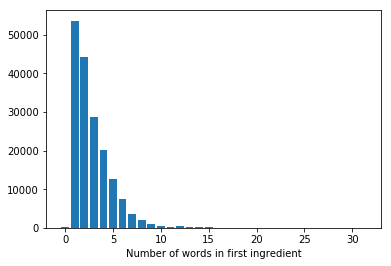

In [16]:
# Observe how many words are in the first ingredient: 
num_words_first = [len(a.split()) for a in first_list1]
counter_first_list1 = collections.Counter(num_words_first)

plt.bar(list(counter_first_list1.keys()), counter_first_list1.values()) 
plt.xlabel("Number of words in first ingredient")
plt.show()

This shows that, even if length of ingredient names are limited to three words or less, there are still ~120000 food items that is parsed into a valid ingredients (based on this criterion).  

In [17]:
# Observe sample of terms of various lengths in the first ingredient
for a in counter_first_list1.keys(): 
    index = [k for k,v in enumerate(num_words_first) if v ==a][0]
    print "\nnumber of words: {}, index: {} \n{}".format(a, index, first_list1[index])


number of words: 0, index: 148 


number of words: 1, index: 1 
water

number of words: 2, index: 3 
tomato puree(water

number of words: 3, index: 9 
organic grain vinegar

number of words: 4, index: 0 
ice cream ingredients: milk

number of words: 5, index: 27 
prepared dark red kidney beans

number of words: 6, index: 106 
parmesan cheese (pasteurized part-skim cow's milk

number of words: 7, index: 157 
enriched macaroni (durum and enriched wheat flour

number of words: 8, index: 334 
blueberries & oats  unbleached wheat flour ( flour

number of words: 9, index: 846 
enriched macaroni product (durum and wheat flour with niacin

number of words: 10, index: 900 
cultured pasteurized grade a lowfat milk and nonfat milk solids

number of words: 11, index: 159 
organic enriched petite pasta shells [organic durum wheat semolina flour (niacin

number of words: 12, index: 1148 
ravioli ingredients: enriched extra fancy durum flour and semolina (durum wheat flour

number of words: 13, inde

- Based on the above observation, some lengthy ingredients are due to lists with no punctuation.  These exceptions are difficult to resolve without a more intensive processes.  
- Ingredient items that include more detailed punctuation-separated ingredients enclosed parentheses/brackets will be cut off after the first detailed ingredient.  This is an ok compromise as it captures at least the main ingredient.  

It is apparent that an exhaustive parsing of ingredients would be a time-consuming task to be done as necessary in future iterations.  

---

## `Use CountVectorizer` to create document term matrix

In [18]:
# Words to remove: ['ingredients', 'ingredient', ...] -- include in stop_words
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS.union('ingredients','ingredient')

In [19]:
# Create vectorizer 
cvectorizer = CountVectorizer(min_df=5, strip_accents="ascii", stop_words='english')

In [20]:
# dtm for entire corpus
dtm = cvectorizer.fit_transform([" ".join(a) for a in list1])

In [21]:
dtm.shape

(175228, 4994)

In [22]:
cvectorizer.vocabulary_.items()[:10]

[(u'vani', 4774),
 (u'bromelain', 682),
 (u'tapioc', 4511),
 (u'albumen', 213),
 (u'propane', 3665),
 (u'pigment', 3477),
 (u'hydrolyzate', 2349),
 (u'caramels', 807),
 (u'probiotic', 3649),
 (u'wholemeal', 4906)]

In [23]:
# sums up the term frequencies for all tokens
dtm.sum(axis=0)

matrix([[  27,   11,   25, ..., 2276,    6,  413]])

Order branded food items according to the amount of common ingredients they have. 

In [24]:
# Show ingredient terms ordered by frequency 

sorted(zip(cvectorizer.get_feature_names(), 
           np.asarray(dtm.sum(axis=0)).ravel()), 
       key=lambda x:x[1], 
       reverse=True)

[(u'salt', 137344),
 (u'sugar', 108814),
 (u'oil', 99586),
 (u'acid', 98236),
 (u'water', 93660),
 (u'flour', 82941),
 (u'organic', 77295),
 (u'corn', 77257),
 (u'milk', 70270),
 (u'natural', 66932),
 (u'wheat', 60386),
 (u'sodium', 55564),
 (u'syrup', 50414),
 (u'flavor', 47558),
 (u'powder', 41026),
 (u'starch', 39584),
 (u'citric', 39528),
 (u'soy', 38292),
 (u'gum', 36073),
 (u'vitamin', 35304),
 (u'juice', 33849),
 (u'color', 32214),
 (u'contains', 31372),
 (u'garlic', 30284),
 (u'soybean', 29961),
 (u'artificial', 29441),
 (u'cheese', 29191),
 (u'red', 26492),
 (u'vinegar', 25046),
 (u'riboflavin', 24916),
 (u'lecithin', 24721),
 (u'flavors', 24636),
 (u'folic', 24472),
 (u'palm', 24218),
 (u'concentrate', 24162),
 (u'modified', 23859),
 (u'niacin', 23818),
 (u'mononitrate', 23805),
 (u'iron', 23379),
 (u'extract', 22937),
 (u'cocoa', 22907),
 (u'butter', 21980),
 (u'vegetable', 21930),
 (u'enriched', 21591),
 (u'calcium', 21447),
 (u'onion', 21326),
 (u'spices', 20609),
 (u'crea

---
The following iterations of `cvectorizer` is to observe how the frequencies change as you expand the corpus from first ingredient to third, fifth, tenth ingredients for each food item.  

In [25]:
# Get first ingredient
first_list1 = [a[0] for a in list1]
first_dtm = cvectorizer.fit_transform(first_list1)

In [26]:
firstingredient_terms = \
sorted(zip(cvectorizer.get_feature_names(), 
           np.asarray(first_dtm.sum(axis=0)).ravel()), 
       key=lambda x:x[1], 
       reverse=True)

In [27]:
three_list1 = [" ".join(a[:3]) for a in list1]

three_dtm = cvectorizer.fit_transform(three_list1)

threeingredients_terms = \
sorted(zip(cvectorizer.get_feature_names(), 
           np.asarray(three_dtm.sum(axis=0)).ravel()), 
       key=lambda x:x[1], 
       reverse=True)

In [28]:
five_list1 = [" ".join(a[:5]) for a in list1]
five_dtm = cvectorizer.fit_transform(five_list1)
fiveingredients_terms = \
sorted(zip(cvectorizer.get_feature_names(), 
           np.asarray(five_dtm.sum(axis=0)).ravel()), 
       key=lambda x:x[1], 
       reverse=True)

In [29]:
ten_list1 = [" ".join(a[:10]) for a in list1]
ten_dtm = cvectorizer.fit_transform(ten_list1)
teningredients_terms = \
sorted(zip(cvectorizer.get_feature_names(), 
           np.asarray(ten_dtm.sum(axis=0)).ravel()), 
       key=lambda x:x[1], 
       reverse=True)

In [30]:

all_terms = \
sorted(zip(cvectorizer.get_feature_names(), 
       np.asarray(dtm.sum(axis=0)).ravel()), 
       key=lambda x:x[1], 
       reverse=True)

In [31]:
pd.DataFrame([firstingredient_terms[:10], 
              threeingredients_terms[:10], 
              fiveingredients_terms[:10], 
              teningredients_terms[:10], 
             all_terms[:10]], 
             index=['one_ingredient', 
                    'three_ingredients', 
                    'five_ingredients', 
                    'ten_ingredients', 
                    'all_ingrdients'])

,0,1,2,3,4,5,6,7,8,9
one_ingredient,"(flour, 31980)","(water, 26866)","(wheat, 23347)","(milk, 19667)","(sugar, 18280)","(organic, 14268)","(enriched, 12913)","(pasteurized, 9449)","(corn, 8007)","(cultured, 5144)"
three_ingredients,"(water, 57154)","(flour, 50920)","(sugar, 48610)","(wheat, 33589)","(organic, 32668)","(milk, 29415)","(corn, 27210)","(oil, 26762)","(salt, 26227)","(syrup, 20825)"
five_ingredients,"(water, 65400)","(sugar, 62269)","(flour, 57158)","(salt, 48389)","(organic, 45384)","(oil, 39950)","(milk, 38729)","(wheat, 38125)","(corn, 37641)","(syrup, 28365)"
ten_ingredients,"(salt, 88445)","(sugar, 87903)","(water, 81210)","(oil, 71697)","(flour, 69249)","(organic, 65673)","(acid, 64868)","(corn, 55034)","(milk, 52313)","(wheat, 46823)"
all_ingrdients,"(solid, 99586)","(add, 98236)","(khorasan, 82941)","(specialty, 77295)","(effect, 77257)","(relish, 70270)","(seeds, 66932)","(jui, 47558)","(turtle, 41026)","(dandelion, 39528)"


In [32]:

all_ing_count = collections.Counter(item for l1 in list1 for item in l1)
all_ing_count.most_common()[:10]

[(u'', 148160),
 (u' salt', 93628),
 (u' sugar', 55625),
 (u' water', 51256),
 (u' citric acid', 29263),
 (u' niacin', 20443),
 (u' riboflavin', 18117),
 (u' corn syrup', 17090),
 (u' natural flavor', 15559),
 (u' folic acid)', 15146)]

In [33]:
first_ing = [a[0].strip() for a in list1]

In [34]:
first_ing_count = collections.Counter(first_ing)
first_ing_count.most_common()[:10]

[(u'sugar', 11232),
 (u'water', 10268),
 (u'carbonated water', 3415),
 (u'filtered water', 2786),
 (u'enriched flour (wheat flour', 2551),
 (u'corn syrup', 2424),
 (u'potatoes', 2102),
 (u'pork', 1854),
 (u'milk', 1809),
 (u'pasteurized milk', 1696)]

In [35]:
three_ing = [a[:3] for a in list1]
three_ing_count = collections.Counter(item.strip() for l1 in three_ing for item in l1)
three_ing_count.most_common()[:10]

[(u'water', 35042),
 (u'sugar', 30828),
 (u'', 18824),
 (u'salt', 18023),
 (u'niacin', 14081),
 (u'corn syrup', 9026),
 (u'reduced iron', 5941),
 (u'high fructose corn syrup', 5450),
 (u'citric acid', 4573),
 (u'cocoa butter', 4241)]

In [36]:
five_ing = [a[:5] for a in list1]
five_ing_count = collections.Counter(item.strip() for l1 in five_ing for item in l1)
five_ing_count.most_common()[:10]

[(u'water', 40740),
 (u'sugar', 38932),
 (u'', 37316),
 (u'salt', 33095),
 (u'niacin', 16725),
 (u'corn syrup', 12027),
 (u'citric acid', 11254),
 (u'reduced iron', 10626),
 (u'thiamine mononitrate', 7860),
 (u'riboflavin', 6792)]

In [37]:
ten_ing = [a[:10] for a in list1]
ten_ing_count = collections.Counter(item.strip() for l1 in ten_ing for item in l1)
ten_ing_count.most_common()[:10]

[(u'', 80809),
 (u'salt', 59886),
 (u'sugar', 54549),
 (u'water', 53272),
 (u'citric acid', 19968),
 (u'niacin', 18785),
 (u'corn syrup', 15524),
 (u'riboflavin', 15333),
 (u'folic acid)', 13393),
 (u'reduced iron', 12355)]

In [38]:
pd.DataFrame([first_ing_count.most_common()[:6], 
              three_ing_count.most_common()[:6], 
              five_ing_count.most_common()[:6], 
              ten_ing_count.most_common()[:6], 
             all_ing_count.most_common()[:6]], 
             index=['one_ingredient', 
                    'three_ingredients', 
                    'five_ingredients', 
                    'ten_ingredients', 
                    'all_ingrdients'])

,0,1,2,3,4,5
one_ingredient,"(sugar, 11232)","(water, 10268)","(carbonated water, 3415)","(filtered water, 2786)","(enriched flour (wheat flour, 2551)","(corn syrup, 2424)"
three_ingredients,"(water, 35042)","(sugar, 30828)","(, 18824)","(salt, 18023)","(niacin, 14081)","(corn syrup, 9026)"
five_ingredients,"(water, 40740)","(sugar, 38932)","(, 37316)","(salt, 33095)","(niacin, 16725)","(corn syrup, 12027)"
ten_ingredients,"(, 80809)","(salt, 59886)","(sugar, 54549)","(water, 53272)","(citric acid, 19968)","(niacin, 18785)"
all_ingrdients,"(, 148160)","( salt, 93628)","( sugar, 55625)","( water, 51256)","( citric acid, 29263)","( niacin, 20443)"


--- 
## Topic modeling 

Obtain TFiDF for all branded food items, the use Latend Dirichlet Allocation method to create categories of branded food items.  

In [39]:
transformer = TfidfTransformer()

In [40]:
tfidfm = transformer.fit_transform(dtm)

In [41]:
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', 
                               learning_offset=50, random_state=0)

lda.fit(tfidfm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_jobs=1, n_topics=10, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [42]:
lda.components_.shape

(10, 4994)

In [43]:
dtm.shape
tfidfm.shape

(175228, 4994)

In [44]:
lda.components_.argsort()[:-10-1:-1][0].shape

(4994,)

In [45]:
for topic_idx, topic in enumerate(lda.components_): 
    print("Topic #%d:" % topic_idx) 
    print(" ".join([cvectorizer.get_feature_names()[i] 
                    for i in topic.argsort()[:-10-1:-1]]))

Topic #0:


IndexError: list index out of range

In [ ]:
topic.argsort?

In [ ]:
lda_topic = []
for topic in lda.components_: 
    lda_topic.append([cvectorizer.get_feature_names()[i] 
                 for i in topic.argsort()[:-10-1:-1]])

In [ ]:
ldatopic_dict = collections.OrderedDict()

In [ ]:
from sklearn.decomposition import NMF 

# Topic modeling using non-negative matrix factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidfm)

for topic_idx, topic in enumerate(nmf.components_): 
    print("Topic #%d:" % topic_idx) 
    print(" ".join([cvectorizer.get_feature_names()[i] 
                    for i in topic.argsort()[:-10-1:-1]
                   ]))

In [ ]:
# Create tfidf vectors for topics to compare cosine similarity 
# with the food items.  
lda_dtm = cvectorizer.transform([" ".join(a) for a in lda_topic])
lda_tfidf = transformer.fit_transform(lda_dtm)
print lda_tfidf.shape


In [ ]:
cosine.max()

In [ ]:
lda_representative_items = []
for i in range(10): 
    cosine = cosine_similarity(lda_tfidf[i],tfidfm)
    index = cosine.argmax()
    lda_representative_items.append((i,index,food_items[index][1], cosine.max()))
    print "For topic # {}, the most representative food item is:\n {}".format(i, food_items[index][1])
    print "Compare topics list vs ingredients list: \n{}\n{}".format([", ".join(lda_topic[i])],[food_items[index][2].lower()])
    print "cosine similarity value is:{} \n".format(cosine.max())

In [ ]:
for n, a in enumerate(lda_representative_items): 
    print "{}: {}, cosine value: {}".format(n, a[2], a[3])

In [ ]:
# Store nmf "topics"
nmf_topic = []
for topic in nmf.components_: 
    nmf_topic.append([cvectorizer.get_feature_names()[i] 
                    for i in topic.argsort()[:-10-1:-1]
                   ])

# Create tfidf vector 
nmf_dtm = cvectorizer.transform([" ".join(a) for a in nmf_topic])
nmf_tfidf = transformer.fit_transform(nmf_dtm) 
print "shape of nmf_tfidf:", nmf_tfidf.shape

for i in range(10): 
    cosine = cosine_similarity(nmf_tfidf[i],tfidfm)
    index = cosine.argmax()
    print "For topic # {}, the most representative food item is:\n {}".format(i, food_items[index][1])
    print "Compare topics list vs ingredients list: \n{}\n{}\n".format([", ".join(nmf_topic[i])],[food_items[index][2].lower()])
    

In [ ]:
# Does it make sense to think about "most un-representative"?
# Apparently, mustard and almonds are least like the rest.  
for i in range(10): 
    cosine = cosine_similarity(lda_tfidf[i],tfidfm)
    index = cosine.argmin()
    print "For topic # {}, the most non-representative food item is:\n {}".format(i, food_items[index][1])
    print "Compare topics list vs ingredients list: \n{}\n{}\n".format([" ".join(lda_topic[i])],[food_items[index][2].lower()])
    

## Questions: 
* How do you determine number of "topics"? 
* Best visualization for lda divisive clustering? 

In [ ]:
# Given the ten topics, cluster the food items around (under) them: top down, divisive clustering
from scipy.cluster.hierarchy import ward, dendogram 
linkage_matrix = ward()

In [ ]:
#unhealthy foods: sugar added 

In [ ]:
lda.components_.shape

In [ ]:
nmf.components_.shape

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [ ]:
km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=5, n_jobs=-1,verbose=1)


In [ ]:
tfidfm_kmeans = km.fit(tfidfm)

In [ ]:
print tfidfm_kmeans.cluster_centers_.shape

# Get items closest to clusters 

for i in range(10): 
    cosine = cosine_similarity(tfidfm_kmeans.cluster_centers_[i].reshape(1,-1),tfidfm)
    index = cosine.argmax()
    print "For centroid # {}, the closest food item is:\n {}".format(i, food_items[index][1])
#    print "Compare topics list vs ingredients list: \n{}\n{}\n".format([" ".join(lda_topic[i])],[food_items[index][2].lower()])
    

In [ ]:
lda_representative_items